2023/3/6<br>
This code is for result visualization

In [1]:
import os
import glob
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from sklearn.neighbors import KernelDensity

In [2]:
current_path=os.getcwd()
npz_path=os.path.join(current_path, "npz_file")
npz_pred_path=os.path.join(npz_path, "pred_im_concatenation")
npz_segmentation_path=os.path.join(npz_path, "segmentation")
fig_save_path=os.path.join(current_path, "fig_save", "result_visualization")

if os.path.exists(fig_save_path)==False:
    os.makedirs(fig_save_path)
    
Polscope_x40=0.160256 #um/pixel
scaling_list=[Polscope_x40**2, Polscope_x40, 1, 1, 1, Polscope_x40**2, Polscope_x40, 1, 1, 1,  Polscope_x40**2, 1, 1, 1, 1, 1, 1, 1]

In [3]:
npz_path_list=glob.glob(os.path.join(npz_pred_path, "*.npz"))
npz_segmentation_path_list=glob.glob(os.path.join(npz_segmentation_path, "*.npz"))

npz_list=[]
for npz_path_ in npz_path_list:
    npz=np.load(npz_path_)
    npz_list.append(npz)
    
npz_segmentation_list=[]
for npz_segmentation_path in npz_segmentation_path_list:
    npz_segmentation=np.load(npz_segmentation_path)
    npz_segmentation_list.append(npz_segmentation)
    
npz=np.load(os.path.join(npz_path, "Dataframe_CWT_MFA_anatomy.npz"), allow_pickle=True)
df_list=npz["df_list"]

Result visualization of each cell species (sample04_whole, tracheid, axial parenchyma)

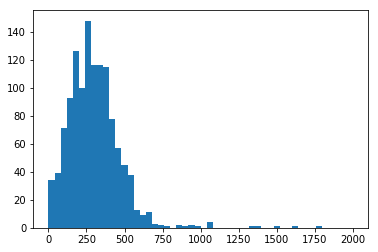

In [6]:
#load data
MFA=npz_list[5]["MFA"]
angle=npz_list[5]["angle"]
pred_binary=npz_list[5]["pred_binary"]
nuclei=npz_segmentation_list[5]["nuclei"]
df=df_list[5]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 2000))
plt.show()

In [11]:
df=df[(df["cell_area"]>75)&(df["cell_area"]<700)]

In [39]:
window_size=400
step_size=200
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 30/30 [00:00<00:00, 396.98it/s]


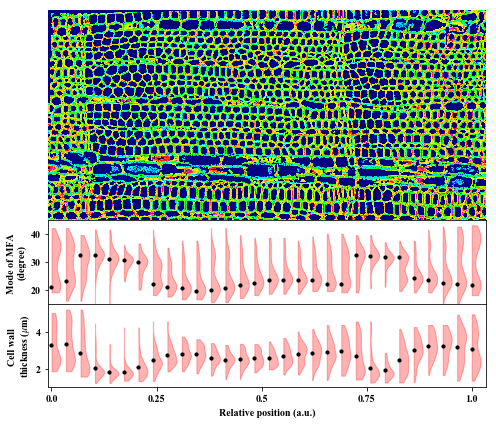

In [47]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(7, 6))
gs = GridSpec(9, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:5, :])
ax2 = plt.subplot(gs[5:7, :])
ax3 = plt.subplot(gs[7:9, :])

ax1.imshow(MFA, cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(15, 45)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(1, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample04_whole_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

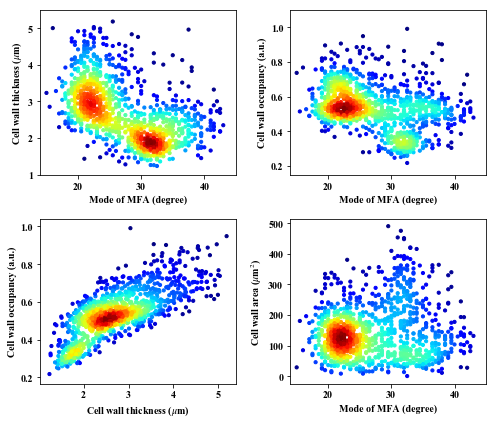

R: -0.5073365808482838
p: 1.1623362047137552e-75


In [46]:
fig, ax=plt.subplots(2, 2, figsize=(7, 6))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0, 0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0, 0].set_ylim(1, 5.5)
ax[0, 0].set_xlim(14, 45)
ax[0, 0].set_xlabel("Mode of MFA (degree)")
ax[0, 0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0, 1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[0, 1].set_ylim(0.15, 1.1)
ax[0, 1].set_xlim(14, 45)
ax[0, 1].set_xlabel("Mode of MFA (degree)")
ax[0, 1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1, 0].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[1, 0].set_xlabel("Cell wall thickness ($\mu$m)")
ax[1, 0].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["MFA_mode"].values, df["lumen_area"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1, 1].scatter(df["MFA_mode"], df["lumen_area"],  c=z, cmap="jet", s=10)
ax[1, 1].set_xlabel("Mode of MFA (degree)")
ax[1, 1].set_ylabel(r"Cell wall area ($\mu$m${^2}$)")
ax[1, 1].set_xlim(14, 45)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample04_whole_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

Result visualization of each cell species (sample04_LW, tracheid, axial parenchyma)

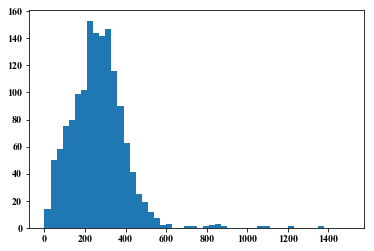

In [48]:
#load data
MFA=npz_list[4]["MFA"]
angle=npz_list[4]["angle"]
pred_binary=npz_list[4]["pred_binary"]
nuclei=npz_segmentation_list[4]["nuclei"]

df=df_list[4]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1500))
plt.show()

In [49]:
df=df[(df["cell_area"]>50)&(df["cell_area"]<600)]

In [52]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 35/35 [00:00<00:00, 400.83it/s]


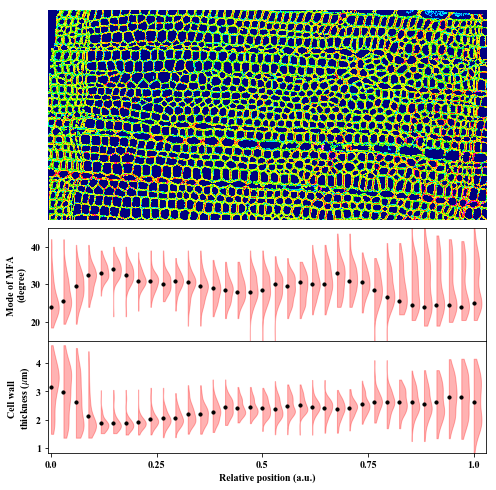

In [69]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(7, 7))
gs = GridSpec(8, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:6, :])
ax3 = plt.subplot(gs[6:8, :])

ax1.imshow(MFA[300:3000], cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(15, 45)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(0.8, 4.8)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample04_LW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

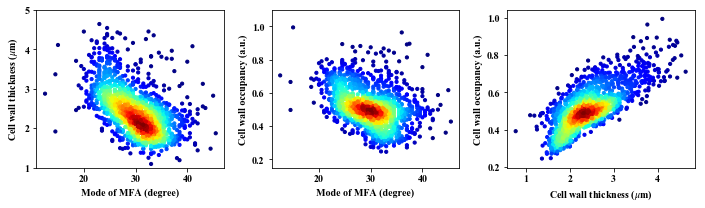

R: -0.5160831262240302
p: 8.565077454012936e-96


In [1146]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0].set_ylim(1, 5)
ax[0].set_ylim(1, 5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.15, 1.1)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample04_LW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

Result visualization of each cell species (sample05_whole, fiber, vessel)

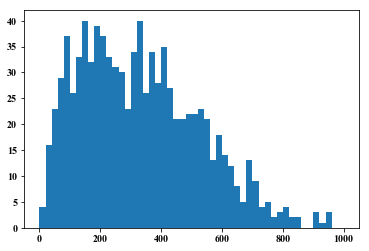

In [70]:
#load data
MFA=npz_list[6]["MFA"]
angle=npz_list[6]["angle"]
pred_binary=npz_list[6]["pred_binary"]
nuclei=npz_segmentation_list[6]["nuclei"]

df=df_list[6]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1000))
plt.show()

In [939]:
df=df[df["cell_area"]>100]

In [71]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 35/35 [00:00<00:00, 426.61it/s]


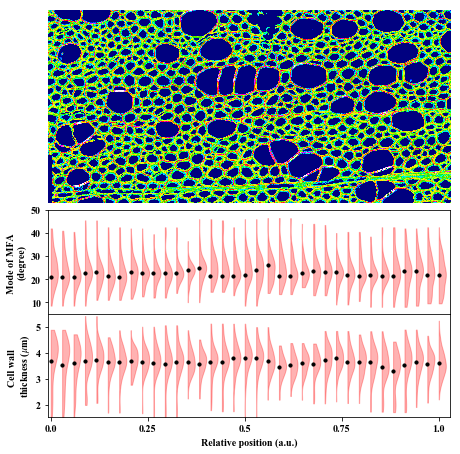

In [82]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(6.5, 6.5))
gs = GridSpec(8, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:6, :])
ax3 = plt.subplot(gs[6:8, :])

ax1.imshow(MFA[300:3000], cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(5, 50)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(1.5, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample05_whole_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

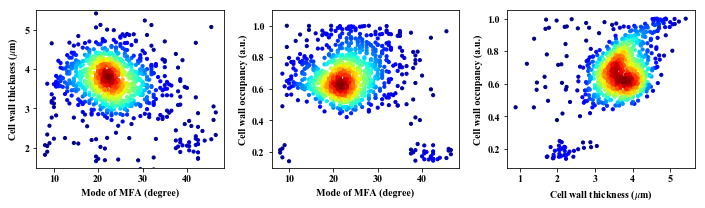

R: -0.21991179890050405
p: 7.59213935754438e-12


In [83]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0].set_ylim(1.5, 5.5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.1, 1.1)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample05_whole_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

Result visualization of each cell species (sample14_EW, thin and thick walled fiber, vessel, axial parenchyma)

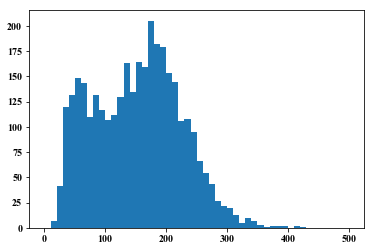

In [84]:
#load data
MFA=npz_list[18]["MFA"]
angle=npz_list[18]["angle"]
pred_binary=npz_list[18]["pred_binary"]
nuclei=npz_segmentation_list[18]["nuclei"]

df=df_list[18]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 500))
plt.show()

In [85]:
df=df[df["cell_area"]>75]

In [86]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 38/38 [00:00<00:00, 387.02it/s]


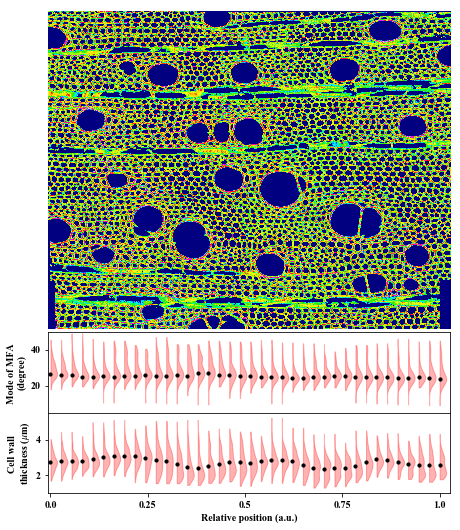

In [93]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(6.5, 7.5))
gs = GridSpec(6, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:5, :])
ax3 = plt.subplot(gs[5:6, :])

ax1.imshow(MFA, cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(5, 50)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(1, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample14_EW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

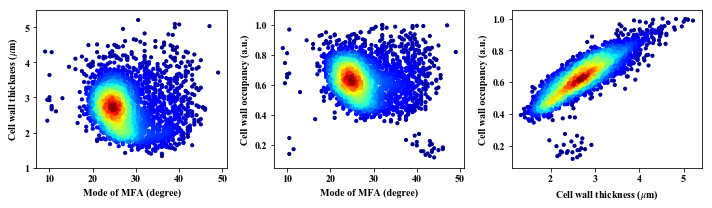

R: -0.07753415771638783
p: 4.623097487043402e-05


In [97]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0].set_ylim(1, 5.5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.05, 1.1)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample14_EW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

sample03 (Quercus salicina, vessel, tracheid, fiber, axial parenchyma, ray parenchyma)

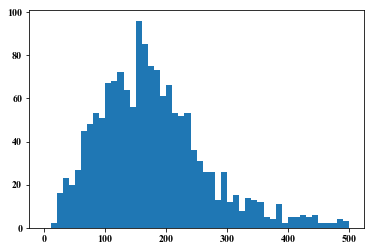

In [107]:
#load data
MFA=npz_list[2]["MFA"]
angle=npz_list[2]["angle"]
pred_binary=npz_list[2]["pred_binary"]
nuclei=npz_segmentation_list[2]["nuclei"]

df=df_list[2]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 500))
plt.show()

In [108]:
df=df[df["cell_area"]>50]

In [109]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 35/35 [00:00<00:00, 415.77it/s]


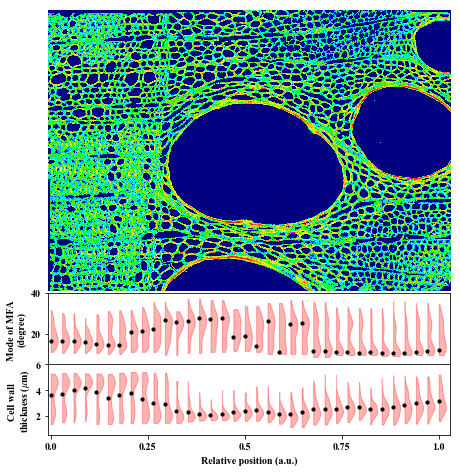

In [121]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(6.5, 6.7))
gs = GridSpec(6, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:5, :])
ax3 = plt.subplot(gs[5:6, :])

ax1.imshow(MFA[:, :5500], cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(5, 40)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(0.5, 6)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample02_EW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

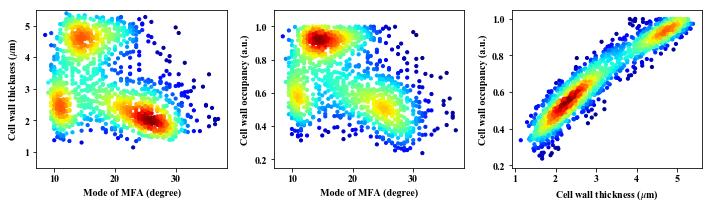

R: -0.33494622340615215
p: 7.889978190027976e-41


In [123]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0].set_ylim(0.5, 5.5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.15, 1.1)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample02_EW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

sample21 Outer (Viburnum, fiber, axial parenchyma, ray parenchyma, vessel)

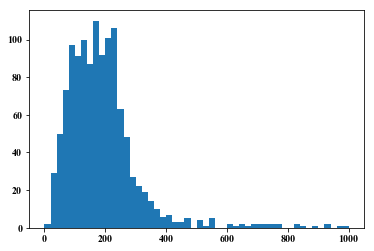

In [124]:
#load data
MFA=npz_list[27]["MFA"]
angle=npz_list[27]["angle"]
pred_binary=npz_list[27]["pred_binary"]
nuclei=npz_segmentation_list[27]["nuclei"]

df=df_list[27]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1000))
plt.show()

In [125]:
df=df[(df["cell_area"]>50)&(df["cell_area"]<6000)]

In [126]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 30/30 [00:00<00:00, 394.61it/s]


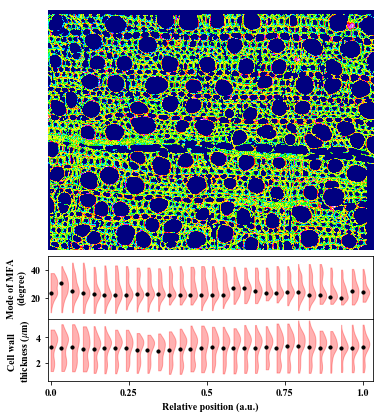

In [130]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(5.5, 6))
gs = GridSpec(6, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:5, :])
ax3 = plt.subplot(gs[5:6, :])

ax1.imshow(MFA, cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(5, 50)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(0.5, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
#plt.savefig(os.path.join(fig_save_path, "sample02_EW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

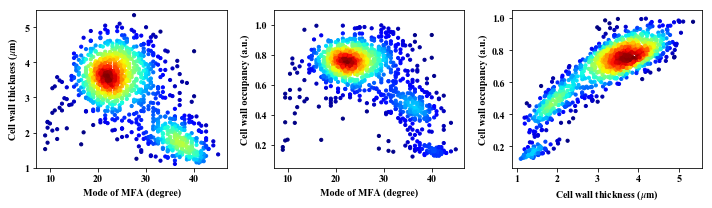

R: -0.5971849372702459
p: 2.852575291281603e-119


In [131]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0].set_ylim(1, 5.5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.05, 1.1)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample21_Outer_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

sample10 EW (Phellodendron amurense, fiber, axial parenchyma, ray parenchyma, vessel)

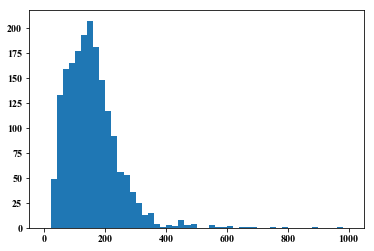

In [132]:
#load data
MFA=npz_list[10]["MFA"]
angle=npz_list[10]["angle"]
pred_binary=npz_list[10]["pred_binary"]
nuclei=npz_segmentation_list[10]["nuclei"]

df=df_list[10]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1000))
plt.show()

In [133]:
df=df[df["cell_area"]>50]

In [134]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 33/33 [00:00<00:00, 391.90it/s]


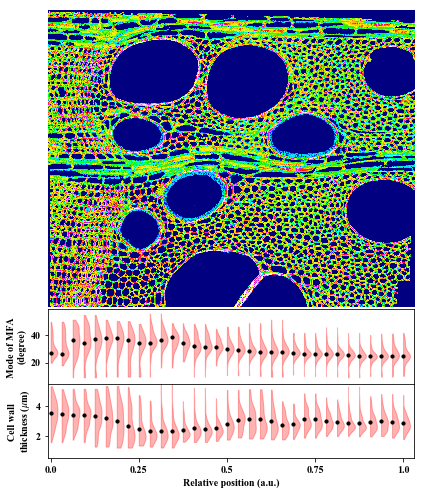

In [138]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(6, 7))
gs = GridSpec(6, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:5, :])
ax3 = plt.subplot(gs[5:6, :])

ax1.imshow(MFA, cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(5, 59)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(0.5, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
#plt.savefig(os.path.join(fig_save_path, "sample02_EW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

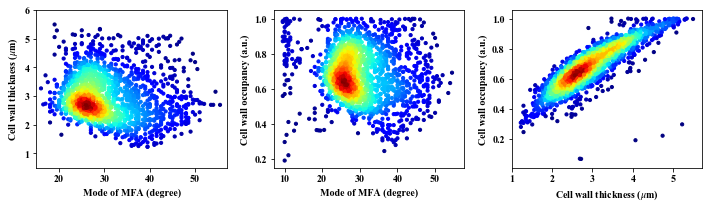

R: -0.20116420562008117
p: 1.621411334588907e-17


In [140]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
ax[0].set_xlim(15, 57)
ax[0].set_ylim(0.5, 6)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.15, 1.05)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample10_EW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

sample10 LW (Phellodendron amurense, fiber, axial parenchyma, ray parenchyma, vessel)

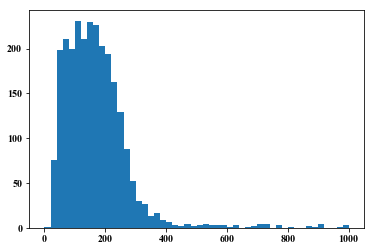

In [141]:
#load data
MFA=npz_list[11]["MFA"]
angle=npz_list[11]["angle"]
pred_binary=npz_list[11]["pred_binary"]
nuclei=npz_segmentation_list[11]["nuclei"]

df=df_list[11]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1000))
plt.show()

In [142]:
df=df[df["cell_area"]>50]

In [143]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 37/37 [00:00<00:00, 393.40it/s]


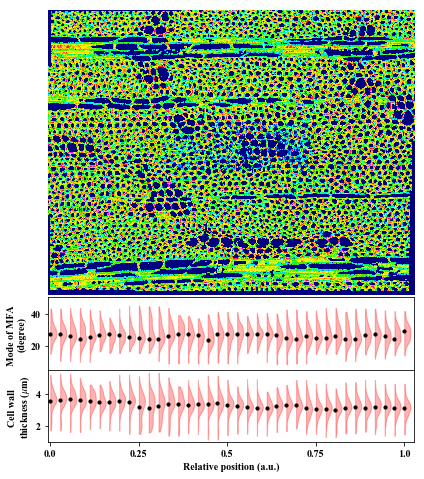

In [152]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(6, 6.8))
gs = GridSpec(6, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:5, :])
ax3 = plt.subplot(gs[5:6, :])

ax1.imshow(MFA[:, :5600], cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(5, 50)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(1, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample10_LW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

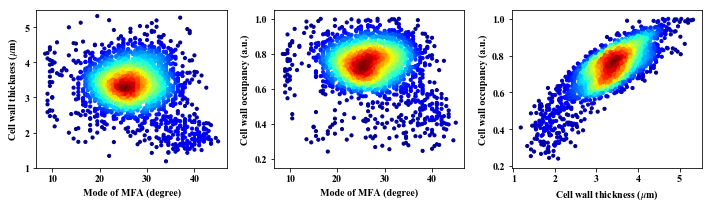

R: -0.21156738408455708
p: 5.705697253255086e-26


In [153]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
#ax[0].set_xlim(10, 57)
ax[0].set_ylim(1, 5.5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.15, 1.05)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample10_LW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

sample11 EW (Rhus chinensis, fiber, vessel, axial parenchyma)

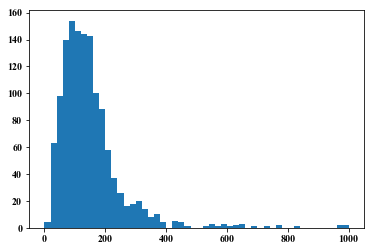

In [154]:
#load data
MFA=npz_list[12]["MFA"]
angle=npz_list[12]["angle"]
pred_binary=npz_list[12]["pred_binary"]
nuclei=npz_segmentation_list[12]["nuclei"]

df=df_list[12]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1000))
plt.show()

In [155]:
df=df[df["cell_area"]>50]

In [156]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 44/44 [00:00<00:00, 420.06it/s]


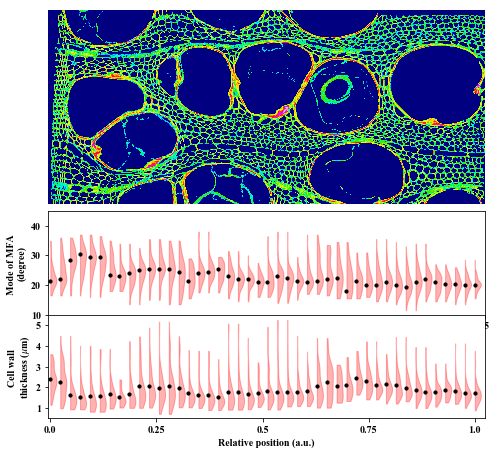

In [165]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(7, 6.5))
gs = GridSpec(8, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:6, :])
ax3 = plt.subplot(gs[6:8, :])

ax1.imshow(MFA, cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(10, 45)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(0.5, 5.5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample11_EW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

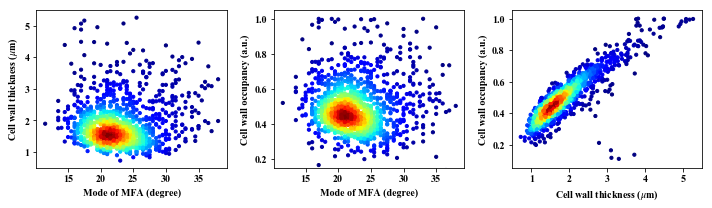

R: 0.07740748470865612
p: 0.006830127928965563


In [168]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
#ax[0].set_xlim(10, 57)
ax[0].set_ylim(0.5, 5.5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.15, 1.05)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample11_EW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))

sample11 LW (Rhus chinensis, fiber, axial parenchyma, vessel)

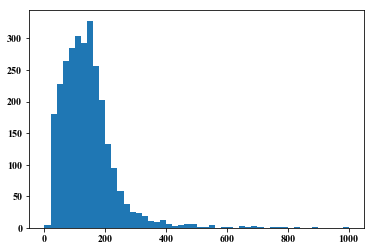

In [169]:
#load data
MFA=npz_list[13]["MFA"]
angle=npz_list[13]["angle"]
pred_binary=npz_list[13]["pred_binary"]
nuclei=npz_segmentation_list[13]["nuclei"]

df=df_list[13]
df=df.dropna(how="any")
df=df[df["cwall_mean"]>0]
df=df*scaling_list

plt.hist(df["cell_area"], bins=50, range=(0, 1000))
plt.show()

In [170]:
df=df[df["cell_area"]>50]

In [171]:
window_size=300
step_size=150
step_num=(MFA.shape[1]-window_size)//step_size

MFA_mean_list=[]
MFA_std_list=[]
MFA_mode_list=[]
MFA_list=[]
x_list=[]

cell_area_list=[]
cellwall_area_list=[]
cellwall_occupancy_list=[]
cwall_mean_list=[]
cwall_list=[]

for i in tqdm(range(step_num)):
    #anatomy
    df_target=df[(df["cell_centroid_x"]>step_size*i) & (df["cell_centroid_x"]<step_size*i+window_size)]
    cell_area=df_target["cell_area"].values
    cellwall_area=df_target["cellwall_area"].values
    cellwall_occupancy=df_target["cellwall_occupancy"].values
    cwall_mean=df_target["cwall_mean"].values
    MFA_modes=df_target["MFA_mode"].values
    
    MFA_mean_list.append(np.median(MFA_modes))
    MFA_std_list.append(np.std(MFA_modes))
    MFA_list.append(MFA_modes)
    x_list.append(np.mean([step_size*i, step_size*i+window_size]))
    
    cell_area_list.append(np.mean(cell_area))
    cellwall_area_list.append(np.mean(cellwall_area))
    cellwall_occupancy_list.append(np.mean(cellwall_occupancy))
    cwall_mean_list.append(np.mean(cwall_mean))
    cwall_list.append(cwall_mean)
    
    #
    X = MFA_modes[:, np.newaxis]
    X_plot = np.linspace(0, 70, 141)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(X)
    log_dens = kde.score_samples(X_plot)
    dens=np.exp(log_dens)
    
    MFA_mode=X_plot[np.argmax(dens)][0]
    MFA_mode_list.append(MFA_mode)
    #MFA_std=np.sqrt(np.sum([dens[j]*((X_plot.flatten()[j]-MFA_mean)**2) for j in range(len(dens))])/np.sum(dens))

100%|██████████| 42/42 [00:00<00:00, 389.00it/s]


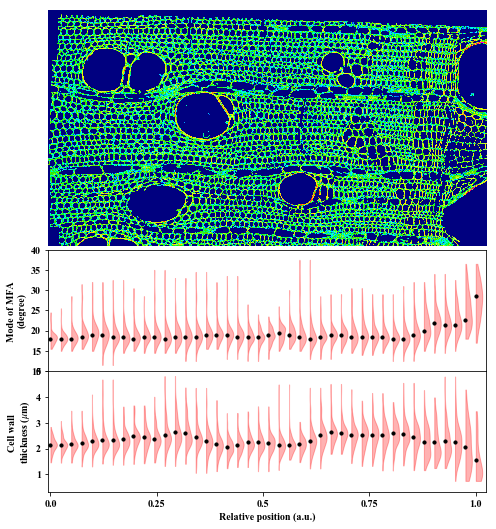

In [177]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['mathtext.fontset']="stix"

fig, ax = plt.subplots(figsize=(7, 7.5))
gs = GridSpec(8, 3, wspace=0, hspace=0)
ax1 = plt.subplot(gs[0:4, :])
ax2 = plt.subplot(gs[4:6, :])
ax3 = plt.subplot(gs[6:8, :])

ax1.imshow(MFA, cmap="gist_ncar", vmin=0, vmax=60)
ax1.axis("off")

v1=ax2.violinplot(MFA_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax2.scatter(np.arange(1, len(MFA_list)+1), MFA_mode_list, c="black", s=10)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')
    #b.set_color('black')

ax2.set_xlim(0.75, len(MFA_list)+1)
ax2.set_ylim(10, 40)
ax2.set_ylabel("Mode of MFA \n(degree)")

v2=ax3.violinplot(cwall_list, points=100,
               showmeans=False, showextrema=False, showmedians=False, widths=1.25)
ax3.scatter(np.arange(1, len(MFA_list)+1), cwall_mean_list, c="black", s=10)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

ax3.set_xlim(0.75, len(MFA_list)+1)
ax3.set_ylim(0.3, 5)
ax3.set_ylabel("Cell wall \nthickness ($\mu$m)")
ax3.set_xlabel("Relative position (a.u.)")
ax3.set_xticks(np.linspace(1, len(MFA_list), 5))
ax3.set_xticklabels(np.linspace(0, 1, 5))
#fig.align_ylabels()
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample11_LW_annual-ring_fluctuation.png"), dpi=1200)
plt.show()
plt.close()

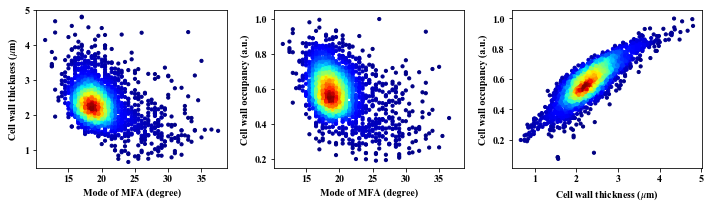

R: -0.3555652315725574
p: 1.6419070431491878e-76


In [180]:
fig, ax=plt.subplots(1, 3, figsize=(10, 3))
xy = np.vstack([df["MFA_mode"].values, df["cwall_mean"].values])
z = stats.gaussian_kde(xy)(xy)
ax[0].scatter(df["MFA_mode"], df["cwall_mean"], c=z, cmap="jet", s=10)
#ax[0].set_xlim(10, 57)
ax[0].set_ylim(0.5, 5)
ax[0].set_xlabel("Mode of MFA (degree)")
ax[0].set_ylabel("Cell wall thickness ($\mu$m)")

xy = np.vstack([df["MFA_mode"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[1].scatter(df["MFA_mode"], df["cellwall_occupancy"], c=z, cmap="jet", s=10)
ax[1].set_ylim(0.15, 1.05)
ax[1].set_xlabel("Mode of MFA (degree)")
ax[1].set_ylabel("Cell wall occupancy (a.u.)")

xy = np.vstack([df["cwall_mean"].values, df["cellwall_occupancy"].values])
z = stats.gaussian_kde(xy)(xy)
ax[2].scatter(df["cwall_mean"], df["cellwall_occupancy"],  c=z, cmap="jet", s=10)
ax[2].set_xlabel("Cell wall thickness ($\mu$m)")
ax[2].set_ylabel("Cell wall occupancy (a.u.)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "sample11_LW_CWT_vs_CWO_vs_MFA.png"), dpi=1200)
plt.show()
plt.close()

print("R: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[0]))
print("p: "+str(stats.pearsonr(df["MFA_mode"], df["cwall_mean"])[1]))